In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, kruskal, linregress
from statsmodels.graphics.gofplots import qqplot
# import scikit_posthocs as sp
import seaborn as sns
from pymannkendall import  hamed_rao_modification_test as hmt


In [3]:
patrick_no2=pd.read_csv('../mydata/hourly_NO2_streets/patrick_hourly_NO2.csv')
patrick_no2.head()

,Timestamp,NO2
0,27-07-2023 11:00,5.035000
1,27-07-2023 12:00,5.360333
2,27-07-2023 13:00,5.173000
3,27-07-2023 14:00,5.743333
4,27-07-2023 15:00,5.773667


In [4]:
patrick_no2 = patrick_no2.dropna(subset=['NO2'])


In [5]:
patrick_no2['hour']=pd.to_datetime(patrick_no2['Timestamp']).dt.hour
patrick_no2.head()

,Timestamp,NO2,hour
0,27-07-2023 11:00,5.035000,11
1,27-07-2023 12:00,5.360333,12
2,27-07-2023 13:00,5.173000,13
3,27-07-2023 14:00,5.743333,14
4,27-07-2023 15:00,5.773667,15


In [6]:
hourly_avg=patrick_no2.groupby('hour')['NO2'].mean().reset_index()
print('Avg NO2 for each hour from July 2023 - June 2024')
print(hourly_avg)

Avg NO2 for each hour from July 2023 - June 2024
    hour        NO2
0      0  15.838615
1      1  14.466190
2      2  13.625905
3      3  12.698018
4      4  11.970882
5      5  12.759137
6      6  16.428424
7      7  18.880912
8      8  18.657605
9      9  16.758798
10    10  14.979121
11    11  13.498682
12    12  12.897394
13    13  12.742787
14    14  13.556177
15    15  13.973281
16    16  16.062380
17    17  17.831534
18    18  19.414294
19    19  20.917435
20    20  22.250111
21    21  21.418409
22    22  20.223093
23    23  18.421197


In [7]:
hourly_avg.to_csv('../mydata/hourly_NO2_streets/individual_hrs_patrick.csv')

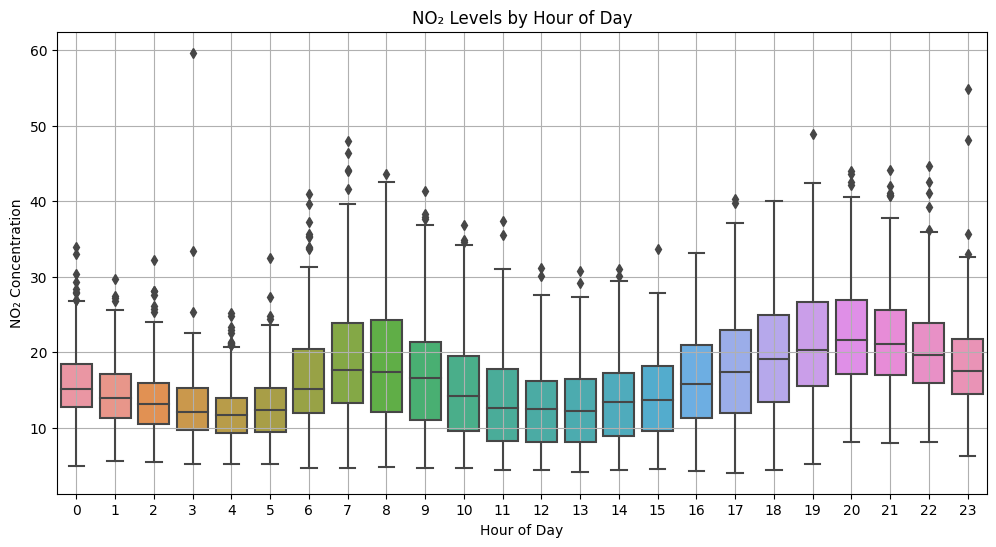

In [8]:
# ------------------------------
# 4. Visualize NO₂ distribution by hour
# ------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='NO2', data=patrick_no2)
plt.title('NO₂ Levels by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration')
plt.grid(True)
plt.show()

In [9]:
patrick_no2.dtypes

Timestamp     object
NO2          float64
hour           int64
dtype: object

In [10]:
print(patrick_no2.isnull().sum())

Timestamp    0
NO2          0
hour         0
dtype: int64


In [11]:

for hr in [0, 3, 6, 12, 15, 18]:
    data = patrick_no2[patrick_no2['hour'] == hr]['NO2']
    print(f"\nHour {hr} summary:")
    print(f"Min: {data.min()}, Max: {data.max()}, Std: {data.std()}, Unique vals: {len(data.unique())}")


Hour 0 summary:
Min: 4.869, Max: 33.91133333, Std: 4.810427120735734, Unique vals: 340

Hour 3 summary:
Min: 5.150333333, Max: 59.66833333, Std: 4.794007597038762, Unique vals: 335

Hour 6 summary:
Min: 4.618333333, Max: 40.95933333, Std: 6.479990201366595, Unique vals: 339

Hour 12 summary:
Min: 4.378, Max: 31.14433333, Std: 5.733395375615534, Unique vals: 339

Hour 15 summary:
Min: 4.459666667, Max: 33.70666667, Std: 5.735336126577921, Unique vals: 342

Hour 18 summary:
Min: 4.359677419, Max: 40.03633333, Std: 7.92609122010621, Unique vals: 342


In [12]:
# ------------------------------
# 5. Check ANOVA assumptions
# ------------------------------

# 5.1 Test for Normality: Shapiro-Wilk Test (for each hour)
normality_results = {}
for hr in range(24):
    data = patrick_no2[patrick_no2['hour'] == hr]['NO2']
    if len(data) >= 3:  # Shapiro requires at least 3 data points
        # print(len(data))
        stat, p = shapiro(data)
        normality_results[hr] = p

# Print results
print("\nShapiro-Wilk Normality Test p-values (per hour):")
for hr, p in normality_results.items():
    print(f"Hour {hr}: p = {p:.4f}")

# All p -values - 1 is unusual happens when either each sample group is very large or thereis no variability in each sample group. 
# result - it was happening because datacontained nan values



Shapiro-Wilk Normality Test p-values (per hour):
Hour 0: p = 0.0000
Hour 1: p = 0.0001
Hour 2: p = 0.0000
Hour 3: p = 0.0000
Hour 4: p = 0.0000
Hour 5: p = 0.0000
Hour 6: p = 0.0000
Hour 7: p = 0.0000
Hour 8: p = 0.0000
Hour 9: p = 0.0000
Hour 10: p = 0.0000
Hour 11: p = 0.0000
Hour 12: p = 0.0000
Hour 13: p = 0.0000
Hour 14: p = 0.0000
Hour 15: p = 0.0000
Hour 16: p = 0.0001
Hour 17: p = 0.0001
Hour 18: p = 0.0010
Hour 19: p = 0.0025
Hour 20: p = 0.0010
Hour 21: p = 0.0000
Hour 22: p = 0.0000
Hour 23: p = 0.0000


### p-values for all hours are less that 0.05. therefore we reject the null hypothesis that the no2 levels at any hour follow a normal distribution 

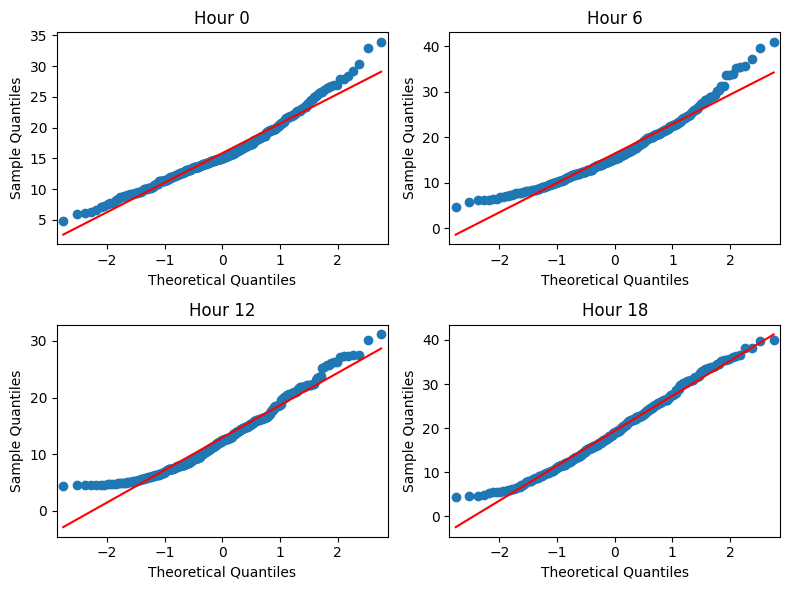

In [13]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing

hours = [0, 6, 12, 18]

# Flatten the 2x2 axes array into 1D for easy iteration
axes = axes.flatten()

for i, hr in enumerate(hours):
    # Extract data for current hour
    data = patrick_no2[patrick_no2['hour'] == hr]['NO2']
    
    # Create QQ plot on the specific subplot axis
    qqplot(data, line='s', ax=axes[i])
    
    # Set title for subplot
    axes[i].set_title(f"Hour {hr}", fontsize=12)

plt.tight_layout()  # Automatically adjust spacing
plt.show()

QQ Plots of NO2 levels at particular hours suggest the same (non normality). Therefore we should refrain from using the one-way ANOVA model and should switch to another NON- PARAMETRIC ALTERNATIVE like KRUSKAL WALLIS H-TEST. It does not assume normality and compares the <b>median</b> across the groups

In [110]:
# !pip install scikit-posthocs
# !pip install pymannkendall
!pip install pygam

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.9 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.9/60.9 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/522.0 kB ? eta -:--:--
   ------------ --------------------------- 163.8/522.0 kB 9.6 MB/s eta 0:00:01
   -------------------------------- ------- 430.1/522.0 kB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 522.0/522.0 kB 5.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.1 kB ? eta -:--:--
   ---------------------------------------- 57.1/57.1 kB 3.1 MB/s eta 0:00:00
   --

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.12.0 requires google-auth-oauthlib<0.5,>=0.4.1, but you have google-auth-oauthlib 1.1.0 which is incompatible.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, r

  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached numpy-2.3.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached pygam-0.9.1-py3-none-any.whl (522 kB)
Using cached progressbar2-4.5.0-py3-none-any.whl (57 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.12.0 requires google-auth-oauthlib<0.5,>=0.4.1, but you have google-auth-oauthlib 1.1.0 which is incompatible.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Figure size 1000x500 with 0 Axes>

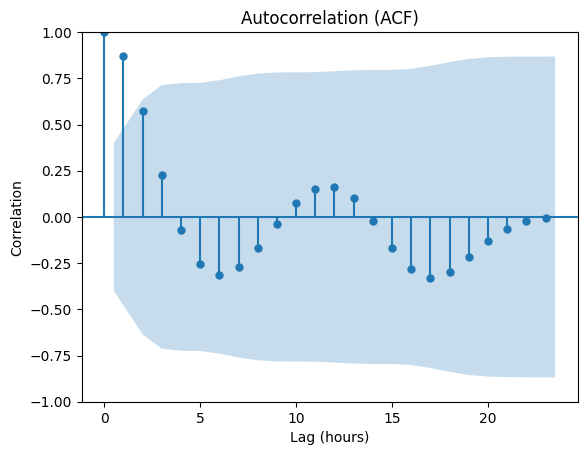

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(10, 5))
plot_acf(hourly_avg['NO2'], lags=23, alpha=0.05)  # 95% confidence interval
plt.title("Autocorrelation (ACF)")
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.show()


In [15]:
mk_result = hmt(hourly_avg['NO2'].values, alpha=0.05)
print("Autocorrelation-adjusted:", mk_result.trend)


Autocorrelation-adjusted: increasing


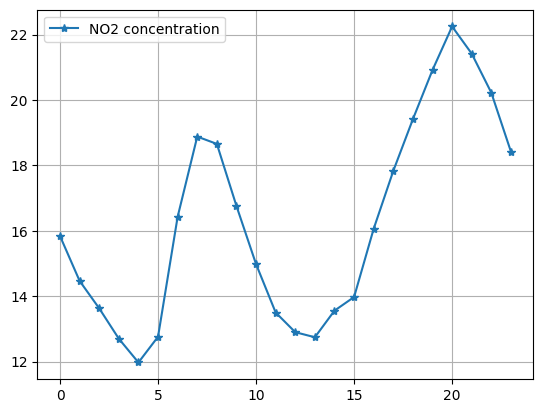

In [16]:
plt.plot(hourly_avg['hour'],hourly_avg['NO2'], marker='*', label='NO2 concentration')
plt.grid(True)
plt.legend()

morning rush - 6 to 

In [17]:
# print(len(hourly_avg)/2)
hourly_avg_d=hourly_avg.drop(columns=['% Change from Prev Hour'], axis=1)
first_half=hourly_avg_d.head(12)
second_half=hourly_avg_d.tail(12)

first_half.sort_values(by='NO2', ascending=True, inplace=True)
second_half.sort_values(by='NO2', ascending=True, inplace=True)

first_half, second_half

KeyError: "['% Change from Prev Hour'] not found in axis"

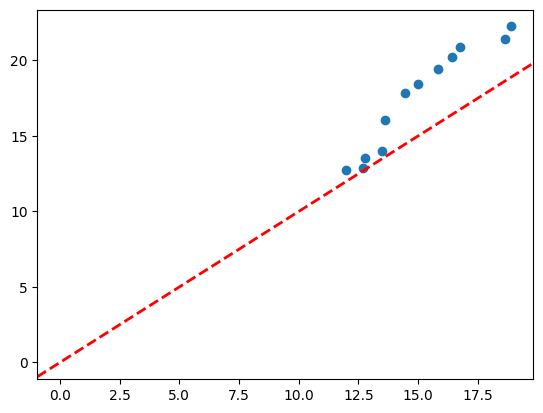

In [ ]:
plt.scatter(first_half['NO2'], second_half['NO2'])
plt.axline((0, 0), (1, 1), linewidth=2, color='r', linestyle='--')

In [ ]:
m1=first_half['NO2'].mean()
m2=second_half['NO2'].mean()

s=2*(m2-m1)/24
s

0.20240140252423075

dividing the day hours into groups

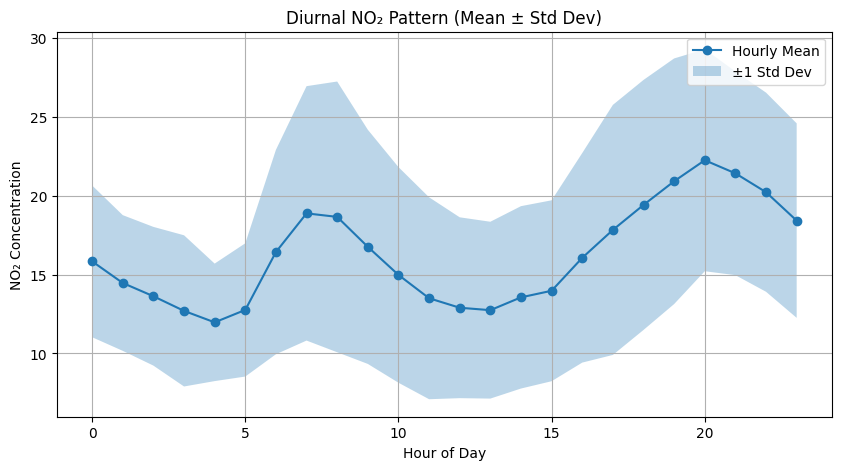

Kruskal-Wallis H-statistic = 1243.870, p-value = 0.0000

Dunn’s Post-Hoc Test (p-values):
               G1 (00–05)    G2 (06–10)     G3 (11–16)     G4 (17–23)
G1 (00–05)   1.000000e+00  1.829579e-48   1.000000e+00  1.041730e-203
G2 (06–10)   1.829579e-48  1.000000e+00   1.342457e-40   6.099047e-42
G3 (11–16)   1.000000e+00  1.342457e-40   1.000000e+00  4.798015e-186
G4 (17–23)  1.041730e-203  6.099047e-42  4.798015e-186   1.000000e+00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf


# Extract time info
patrick_no2['hour'] = pd.to_datetime(patrick_no2['Timestamp']).dt.hour
patrick_no2['date'] = pd.to_datetime(patrick_no2['Timestamp']).dt.date

# 2. Group into time-of-day categories
def assign_group(hour):
    if 0 <= hour <= 5:
        return 'G1 (00–05)'
    elif 6 <= hour <= 10:
        return 'G2 (06–10)'
    elif 11 <= hour <= 16:
        return 'G3 (11–16)'
    else:
        return 'G4 (17–23)'

patrick_no2['time_group'] = patrick_no2['hour'].apply(assign_group)

# 3. Visualize hourly averages
hourly_avg_std = patrick_no2.groupby('hour')['NO2'].agg(['mean', 'std'])
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg_std.index, hourly_avg_std['mean'], marker='o', label='Hourly Mean')
plt.fill_between(hourly_avg_std.index, 
                 hourly_avg_std['mean'] - hourly_avg_std['std'],
                 hourly_avg_std['mean'] + hourly_avg_std['std'],
                 alpha=0.3, label='±1 Std Dev')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration')
plt.title('Diurnal NO₂ Pattern (Mean ± Std Dev)')
plt.grid(True)
plt.legend()
plt.show()

# 4. Kruskal-Wallis Test (non-parametric ANOVA)
groups = [group['NO2'].values for name, group in patrick_no2.groupby('time_group')]
kw_stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {kw_stat:.3f}, p-value = {p_value:.4f}")

# 5. Dunn’s Test for pairwise comparisons
dunn_result = sp.posthoc_dunn(patrick_no2, val_col='NO2', group_col='time_group', p_adjust='bonferroni')
print("\nDunn’s Post-Hoc Test (p-values):")
print(dunn_result)

p-value obtained from kruskal wallis h-test reveals that the NO2 levels vary significantly by the hour of the day 

In [19]:
# Quantify % differences in group means
means = patrick_no2.groupby('time_group')['NO2'].mean().round(2)
print(means)

# Calculate pairwise % increases
pct_diff = (means["G4 (17–23)"] - means["G1 (00–05)"]) / means["G1 (00–05)"] * 100
print(f"Evening NO₂ is {pct_diff:.1f}% higher than early morning.")

time_group
G1 (00–05)    13.56
G2 (06–10)    17.14
G3 (11–16)    13.79
G4 (17–23)    20.07
Name: NO2, dtype: float64
Evening NO₂ is 48.0% higher than early morning.


In [20]:
# 6. Optional: Fit a GLS (Generalized Least Squares) Model
from statsmodels.regression.linear_model import GLSAR

# Encode time group
patrick_no2['group_code'] = patrick_no2['time_group'].astype('category').cat.codes
y = patrick_no2['NO2']
X = sm.add_constant(patrick_no2['group_code'])

# Fit GLSAR model with lag 1
model_glsar = GLSAR(y, X, rho=1)
res_glsar = model_glsar.iterative_fit(maxiter=10)
print(res_glsar.summary())

                           GLSAR Regression Results                           
Dep. Variable:                    NO2   R-squared:                       0.034
Model:                          GLSAR   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     284.2
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           1.07e-62
Time:                        17:24:40   Log-Likelihood:                -22437.
No. Observations:                8164   AIC:                         4.488e+04
Df Residuals:                    8162   BIC:                         4.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6166      0.268     54.449      0.0

The GSLAR model reveals that time-of-day groupings significantly predicted NO₂ levels (F(1, 8162) = 284.2, p < 0.0001), with concentrations rising by approximately 1.05 µg/m³ per time block from early morning to late evening. Although the model explained 3.4% of the variance (R² = 0.034), the time-of-day effect was statistically significant. Diagnostics suggest that autocorrelation was well-accounted for (Durbin-Watson = 1.79), though residuals showed some skew and kurtosis.

R-squared=0.034
this means that the groupings explain only 3.4% of the variance in NO2 (this proves that No2 is dependent on other drivers as well like -- weather, season, may be traffic and more) but this is highly significant as compared to the case when there were no groupings. 

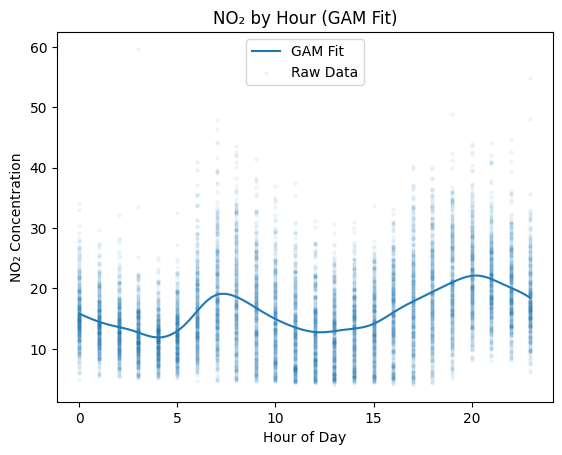

In [21]:
from pygam import LinearGAM, s

gam = LinearGAM(s(0)).fit(patrick_no2[['hour']], patrick_no2['NO2'])
XX = np.linspace(0, 23, 100)
plt.plot(XX, gam.predict(XX), label='GAM Fit')
plt.scatter(patrick_no2['hour'], patrick_no2['NO2'], alpha=0.05, s=5, label='Raw Data')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration')
plt.title('NO₂ by Hour (GAM Fit)')
plt.legend()
plt.show()

### Weekend vs Weekday

In [22]:
patrick_no2['weekday']=pd.to_datetime(patrick_no2['Timestamp']).dt.day_of_week
patrick_no2.head()

,Timestamp,NO2,hour,date,time_group,group_code,weekday
0,27-07-2023 11:00,5.035000,11,2023-07-27,G3 (11–16),2,3
1,27-07-2023 12:00,5.360333,12,2023-07-27,G3 (11–16),2,3
2,27-07-2023 13:00,5.173000,13,2023-07-27,G3 (11–16),2,3
3,27-07-2023 14:00,5.743333,14,2023-07-27,G3 (11–16),2,3
4,27-07-2023 15:00,5.773667,15,2023-07-27,G3 (11–16),2,3


In [23]:
weekdays_df=patrick_no2[~((patrick_no2['weekday']==5) | (patrick_no2['weekday']==6))]
weekend_df=patrick_no2[(patrick_no2['weekday']==5) | (patrick_no2['weekday']==6)]

In [24]:
weekdays_df['weekday'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

In [25]:
weekend_df['weekday'].unique()

array([5, 6], dtype=int64)

In [26]:
weekday_hourly_avg=weekdays_df.groupby('hour')['NO2'].mean()
weekend_hourly_avg=weekend_df.groupby('hour')['NO2'].mean()
print(weekday_hourly_avg)

hour
0     15.398774
1     14.088891
2     13.089483
3     12.452922
4     12.125808
5     13.289585
6     17.682172
7     20.298329
8     20.269624
9     17.774879
10    15.609721
11    13.858653
12    13.052638
13    12.842331
14    13.524808
15    13.967633
16    16.066672
17    17.764708
18    19.318998
19    20.874161
20    22.334759
21    21.486713
22    20.337021
23    18.416409
Name: NO2, dtype: float64


In [27]:
print(weekend_hourly_avg)

hour
0     16.909340
1     15.390187
2     14.926322
3     13.289715
4     11.595305
5     11.473204
6     13.389035
7     15.459066
8     14.709806
9     14.260069
10    13.428360
11    12.609773
12    12.514035
13    12.495958
14    13.633172
15    13.987146
16    16.051846
17    17.995562
18    19.648200
19    21.024092
20    22.041484
21    21.250062
22    19.942302
23    18.432995
Name: NO2, dtype: float64


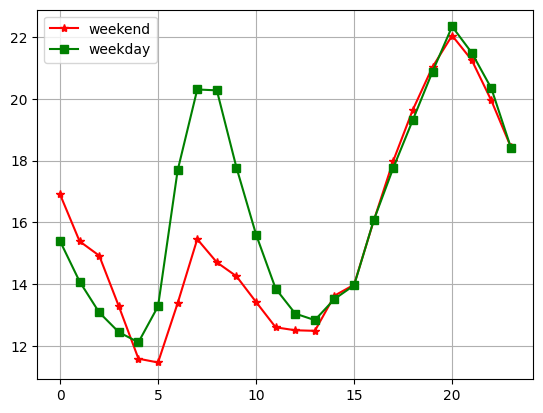

In [30]:
plt.plot(weekend_hourly_avg, marker='*', color='red',label='weekend')
plt.plot(weekday_hourly_avg, marker='s', color='green', label='weekday')

plt.grid()
plt.legend()


In [31]:
weekday_hourly_avg.to_csv('../mydata/hourly_NO2_streets/weekday hourly avg.csv')
weekend_hourly_avg.to_csv('../mydata/hourly_NO2_streets/weekend hourly avg.csv')


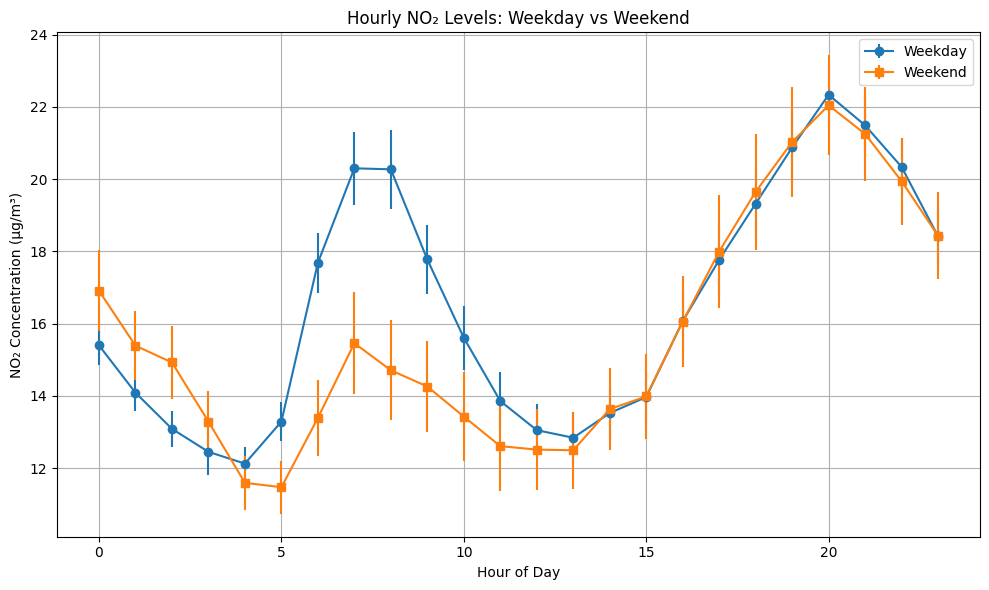

Hours with significant difference after correction: [2, 5, 6, 7, 8, 9]


In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Step 1: Preprocess
patrick_no2['Timestamp'] = pd.to_datetime(patrick_no2['Timestamp'])
patrick_no2['hour'] = patrick_no2['Timestamp'].dt.hour
patrick_no2['weekday'] = patrick_no2['Timestamp'].dt.weekday  # Monday=0, Sunday=6
patrick_no2['is_weekend'] =patrick_no2['weekday'] >= 5

# Separate
weekdays = patrick_no2[~patrick_no2['is_weekend']]
weekends = patrick_no2[patrick_no2['is_weekend']]

# Step 2: Aggregate means and SE
def mean_se_group(df):
    grouped = df.groupby('hour')['NO2']
    mean = grouped.mean()
    se = grouped.std() / np.sqrt(grouped.count())
    return mean, se

mean_wd, se_wd = mean_se_group(weekdays)
mean_we, se_we = mean_se_group(weekends)

# Step 3: Plot
hours = range(24)
plt.figure(figsize=(10,6))
plt.errorbar(hours, mean_wd, yerr=1.96*se_wd, label='Weekday', fmt='-o')
plt.errorbar(hours, mean_we, yerr=1.96*se_we, label='Weekend', fmt='-s')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration (µg/m³)')
plt.title('Hourly NO₂ Levels: Weekday vs Weekend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Hour-wise t-tests
p_values = []
for hr in hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    _, p = ttest_ind(wd_vals, we_vals, equal_var=False)
    p_values.append(p)

# Correct for multiple testing (Bonferroni)
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Show significant hours
significant_hours = [hr for hr, sig in zip(hours, rejected) if sig]
print("Hours with significant difference after correction:", significant_hours)


In [37]:
# Step 5: Quantify differences for significant hours
results = []

for hr in significant_hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    
    wd_mean = wd_vals.mean()
    we_mean = we_vals.mean()
    
    wd_std = wd_vals.std()
    we_std = we_vals.std()
    
    n_wd = len(wd_vals)
    n_we = len(we_vals)
    
    # Percent difference relative to weekend
    percent_diff = ((wd_mean - we_mean) / we_mean) * 100
    
    # Pooled standard deviation for Cohen's d
    pooled_std = np.sqrt(((n_wd - 1) * wd_std**2 + (n_we - 1) * we_std**2) / (n_wd + n_we - 2))
    cohens_d = (wd_mean - we_mean) / pooled_std
    
    results.append({
        'Hour': hr,
        'Weekday Mean': round(wd_mean, 2),
        'Weekend Mean': round(we_mean, 2),
        'Mean Difference': round(wd_mean - we_mean, 2),
        '% Difference': round(percent_diff, 2),
        "Cohen's d": round(cohens_d, 2),
        'Direction': 'Weekday > Weekend' if wd_mean > we_mean else 'Weekday < Weekend'
    })

# Create and display DataFrame
diff_summary = pd.DataFrame(results)
print(diff_summary)


   Hour  Weekday Mean  Weekend Mean  Mean Difference  % Difference  Cohen's d  \
0     2         13.09         14.93            -1.84        -12.31      -0.42   
1     5         13.29         11.47             1.82         15.83       0.44   
2     6         17.68         13.39             4.29         32.06       0.69   
3     7         20.30         15.46             4.84         31.30       0.62   
4     8         20.27         14.71             5.56         37.80       0.68   
5     9         17.77         14.26             3.51         24.65       0.48   

           Direction  
0  Weekday < Weekend  
1  Weekday > Weekend  
2  Weekday > Weekend  
3  Weekday > Weekend  
4  Weekday > Weekend  
5  Weekday > Weekend  


In [38]:
# Classify effect size magnitude
def classify_effect_size(d):
    abs_d = abs(d)
    if abs_d < 0.2:
        return 'Very Small'
    elif abs_d < 0.5:
        return 'Small'
    elif abs_d < 0.8:
        return 'Medium'
    else:
        return 'Large'

diff_summary['Effect Size'] = diff_summary['Cohen\'s d'].apply(classify_effect_size)

# Display updated DataFrame
print(diff_summary)

   Hour  Weekday Mean  Weekend Mean  Mean Difference  % Difference  Cohen's d  \
0     2         13.09         14.93            -1.84        -12.31      -0.42   
1     5         13.29         11.47             1.82         15.83       0.44   
2     6         17.68         13.39             4.29         32.06       0.69   
3     7         20.30         15.46             4.84         31.30       0.62   
4     8         20.27         14.71             5.56         37.80       0.68   
5     9         17.77         14.26             3.51         24.65       0.48   

           Direction Effect Size  
0  Weekday < Weekend       Small  
1  Weekday > Weekend       Small  
2  Weekday > Weekend      Medium  
3  Weekday > Weekend      Medium  
4  Weekday > Weekend      Medium  
5  Weekday > Weekend       Small  


In [51]:
diff_summary

,Hour,Weekday Mean,Weekend Mean,Mean Difference,% Difference,Cohen's d,Direction,Effect Size
0,2,13.09,14.93,-1.84,-12.31,-0.42,Weekday < Weekend,Small
1,5,13.29,11.47,1.82,15.83,0.44,Weekday > Weekend,Small
2,6,17.68,13.39,4.29,32.06,0.69,Weekday > Weekend,Medium
3,7,20.30,15.46,4.84,31.30,0.62,Weekday > Weekend,Medium
4,8,20.27,14.71,5.56,37.80,0.68,Weekday > Weekend,Medium
5,9,17.77,14.26,3.51,24.65,0.48,Weekday > Weekend,Small


### FOR UCC DATA

In [13]:
ucc_no2=pd.read_csv('../mydata/hourly_NO2_streets/UCC_hourly_NO2.csv')
ucc_no2 = ucc_no2.dropna(subset=['NO2'])

ucc_no2.head()

<IPython.core.display.Javascript object>

,Timestamp,NO2
0,07-01-2020 00:00,1.89
1,07-01-2020 01:00,1.79
2,07-01-2020 02:00,1.64
3,07-01-2020 03:00,1.78
4,07-01-2020 04:00,2.06


In [ ]:
ucc_no2['weekday']=pd.to_datetime(ucc_no2['Timestamp']).dt.day_of_week
ucc_no2['hour']=pd.to_datetime(ucc_no2['Timestamp']).dt.hour

ucc_no2.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Timestamp,NO2,weekday,hour
0,07-01-2020 00:00,1.89,2,0
1,07-01-2020 01:00,1.79,2,1
2,07-01-2020 02:00,1.64,2,2
3,07-01-2020 03:00,1.78,2,3
4,07-01-2020 04:00,2.06,2,4


In [15]:
weekdays_df=ucc_no2[~((ucc_no2['weekday']==5) | (ucc_no2['weekday']==6))]
weekend_df=ucc_no2[(ucc_no2['weekday']==5) | (ucc_no2['weekday']==6)]

print(weekdays_df['weekday'].unique())
print(weekend_df['weekday'].unique())

weekday_hourly_avg=weekdays_df.groupby('hour')['NO2'].mean()
weekend_hourly_avg=weekend_df.groupby('hour')['NO2'].mean()
print(weekday_hourly_avg)

print(weekend_hourly_avg)

[2 1 3 4 0]
[5 6]
hour
0      7.205681
1      6.006017
2      5.329719
3      4.946325
4      4.812316
5      5.050609
6      6.260783
7      9.578627
8     13.263619
9     13.756044
10    12.003843
11     9.709670
12     8.172318
13     7.123479
14     7.019030
15     7.284327
16     7.992119
17     9.407222
18    10.577687
19    11.218183
20    11.579436
21    11.460146
22    10.513473
23     8.920993
Name: NO2, dtype: float64
hour
0     7.869558
1     6.714307
2     6.243912
3     5.746675
4     5.226667
5     4.765686
6     4.958649
7     6.278701
8     7.925528
9     8.341941
10    7.781907
11    6.974634
12    6.050978
13    5.519195
14    5.289561
15    5.229537
16    5.660925
17    6.765073
18    7.967015
19    8.974161
20    9.713592
21    9.700146
22    9.605756
23    8.382895
Name: NO2, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

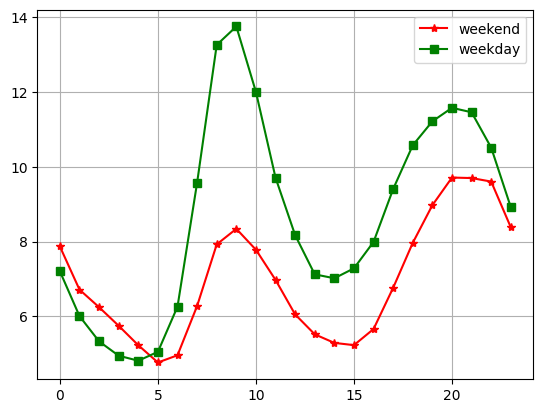

In [16]:
plt.plot(weekend_hourly_avg, marker='*', color='red',label='weekend')
plt.plot(weekday_hourly_avg, marker='s', color='green', label='weekday')

plt.grid()
plt.legend()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

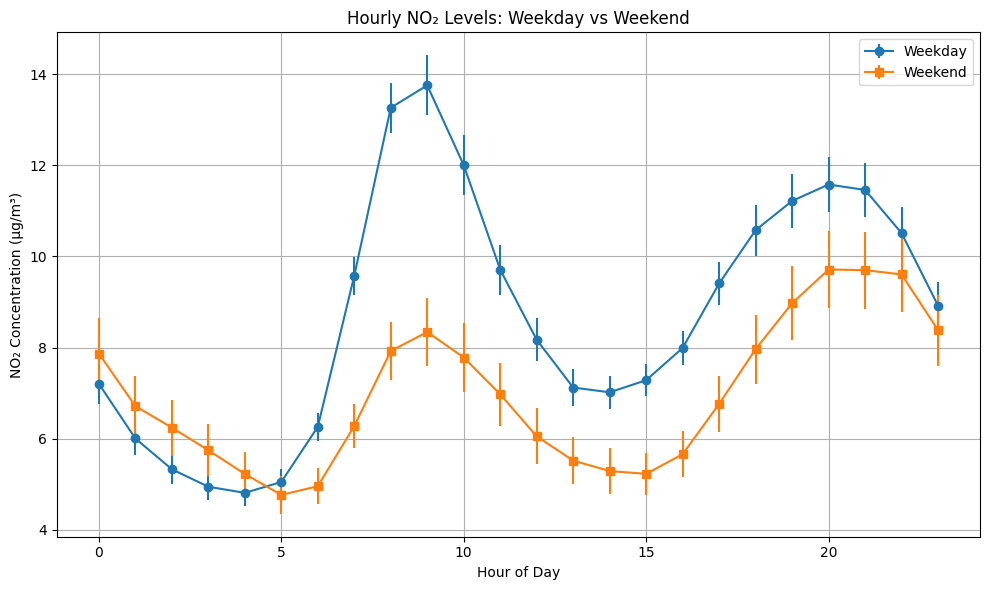

Hours with significant difference after correction: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [17]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Step 1: Preprocess
ucc_no2['Timestamp'] = pd.to_datetime(ucc_no2['Timestamp'])
ucc_no2['hour'] = ucc_no2['Timestamp'].dt.hour
ucc_no2['weekday'] = ucc_no2['Timestamp'].dt.weekday  # Monday=0, Sunday=6
ucc_no2['is_weekend'] =ucc_no2['weekday'] >= 5

# Separate
weekdays = ucc_no2[~ucc_no2['is_weekend']]
weekends = ucc_no2[ucc_no2['is_weekend']]

# Step 2: Aggregate means and SE
def mean_se_group(df):
    grouped = df.groupby('hour')['NO2']
    mean = grouped.mean()
    se = grouped.std() / np.sqrt(grouped.count())
    return mean, se

mean_wd, se_wd = mean_se_group(weekdays)
mean_we, se_we = mean_se_group(weekends)

# Step 3: Plot
hours = range(24)
plt.figure(figsize=(10,6))
plt.errorbar(hours, mean_wd, yerr=1.96*se_wd, label='Weekday', fmt='-o')
plt.errorbar(hours, mean_we, yerr=1.96*se_we, label='Weekend', fmt='-s')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration (µg/m³)')
plt.title('Hourly NO₂ Levels: Weekday vs Weekend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Hour-wise t-tests
p_values = []
for hr in hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    _, p = ttest_ind(wd_vals, we_vals, equal_var=False)
    p_values.append(p)
# Correct for multiple testing (Bonferroni)
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Show significant hours
significant_hours = [hr for hr, sig in zip(hours, rejected) if sig]
print("Hours with significant difference after correction:", significant_hours)


In [ ]:
# Step 5: Quantify differences for significant hours
results = []

for hr in significant_hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    
    wd_mean = wd_vals.mean()
    we_mean = we_vals.mean()
    
    wd_std = wd_vals.std()
    we_std = we_vals.std()
    
    n_wd = len(wd_vals)
    n_we = len(we_vals)
    
    # Percent difference relative to weekend
    percent_diff = ((wd_mean - we_mean) / we_mean) * 100
    
    # Pooled standard deviation for Cohen's d
    pooled_std = np.sqrt(((n_wd - 1) * wd_std**2 + (n_we - 1) * we_std**2) / (n_wd + n_we - 2))
    cohens_d = (wd_mean - we_mean) / pooled_std
    
    results.append({
        'Hour': hr,
        'Weekday Mean': round(wd_mean, 2),
        'Weekend Mean': round(we_mean, 2),
        'Mean Difference': round(wd_mean - we_mean, 2),
        '% Difference': round(percent_diff, 2),
        "Cohen's d": round(cohens_d, 2),
        'Direction': 'Weekday > Weekend' if wd_mean > we_mean else 'Weekday < Weekend'
    })

# Create and display DataFrame
diff_summary = pd.DataFrame(results)
diff_summary

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Hour,Weekday Mean,Weekend Mean,Mean Difference,% Difference,Cohen's d,Direction
0,6,6.26,4.96,1.30,26.26,0.27,Weekday > Weekend
1,7,9.58,6.28,3.30,52.56,0.52,Weekday > Weekend
2,8,13.26,7.93,5.34,67.35,0.63,Weekday > Weekend
3,9,13.76,8.34,5.41,64.90,0.54,Weekday > Weekend
4,10,12.00,7.78,4.22,54.25,0.42,Weekday > Weekend
5,11,9.71,6.97,2.74,39.21,0.32,Weekday > Weekend
6,12,8.17,6.05,2.12,35.06,0.29,Weekday > Weekend
7,13,7.12,5.52,1.60,29.07,0.26,Weekday > Weekend
8,14,7.02,5.29,1.73,32.70,0.30,Weekday > Weekend
9,15,7.28,5.23,2.05,39.29,0.38,Weekday > Weekend


### oliver 

In [21]:
op_no2=pd.read_csv('../mydata/hourly_NO2_streets/oliver_hourly_NO2.csv')
op_no2 = op_no2.dropna(subset=['NO2'])

op_no2.head()
op_no2['weekday']=pd.to_datetime(op_no2['Timestamp']).dt.day_of_week
op_no2['hour']=pd.to_datetime(op_no2['Timestamp']).dt.hour

op_no2.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Timestamp,NO2,weekday,hour
0,06-08-2023 16:00,4.986364,3,16
1,06-08-2023 17:00,5.473333,3,17
2,06-08-2023 18:00,4.498000,3,18
3,06-08-2023 19:00,8.257000,3,19
4,06-08-2023 20:00,18.923333,3,20


In [22]:
weekdays_df=op_no2[~((op_no2['weekday']==5) | (op_no2['weekday']==6))]
weekend_df=op_no2[(op_no2['weekday']==5) | (op_no2['weekday']==6)]

print(weekdays_df['weekday'].unique())
print(weekend_df['weekday'].unique())

weekday_hourly_avg=weekdays_df.groupby('hour')['NO2'].mean()
weekend_hourly_avg=weekend_df.groupby('hour')['NO2'].mean()
print(weekday_hourly_avg)

print(weekend_hourly_avg)

[3 1 4 2 0]
[5 6]
hour
0     16.016357
1     15.145970
2     14.601562
3     14.122719
4     13.955050
5     14.946231
6     17.039736
7     20.362142
8     20.640826
9     18.220477
10    15.753335
11    13.391367
12    12.004618
13    11.369086
14    12.020179
15    13.212678
16    14.851744
17    16.201401
18    17.039767
19    18.395020
20    19.988951
21    19.747719
22    18.762318
23    17.536777
Name: NO2, dtype: float64
hour
0     16.456521
1     15.641775
2     15.302638
3     14.175773
4     13.514681
5     13.734559
6     14.952670
7     16.645708
8     17.175537
9     15.903453
10    14.262620
11    12.566450
12    11.961479
13    11.641364
14    12.304588
15    13.123069
16    14.488222
17    15.605249
18    16.432722
19    17.915788
20    18.952477
21    18.587956
22    17.739952
23    16.739722
Name: NO2, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

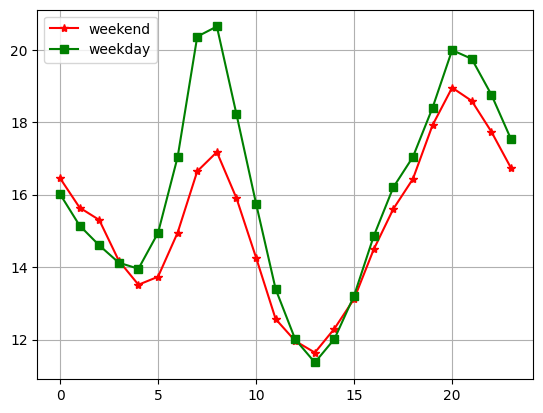

In [23]:
plt.plot(weekend_hourly_avg, marker='*', color='red',label='weekend')
plt.plot(weekday_hourly_avg, marker='s', color='green', label='weekday')

plt.grid()
plt.legend()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

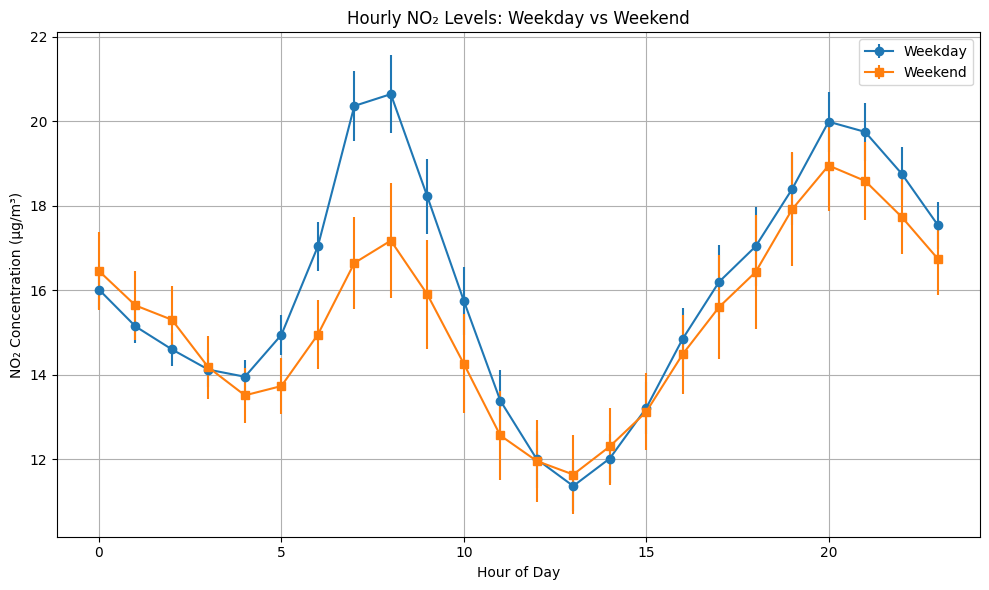

Hours with significant difference after correction: [6, 7, 8]


In [24]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Step 1: Preprocess
op_no2['Timestamp'] = pd.to_datetime(op_no2['Timestamp'])
op_no2['hour'] = op_no2['Timestamp'].dt.hour
op_no2['weekday'] = op_no2['Timestamp'].dt.weekday  # Monday=0, Sunday=6
op_no2['is_weekend'] =op_no2['weekday'] >= 5

# Separate
weekdays = op_no2[~op_no2['is_weekend']]
weekends = op_no2[op_no2['is_weekend']]

# Step 2: Aggregate means and SE
def mean_se_group(df):
    grouped = df.groupby('hour')['NO2']
    mean = grouped.mean()
    se = grouped.std() / np.sqrt(grouped.count())
    return mean, se

mean_wd, se_wd = mean_se_group(weekdays)
mean_we, se_we = mean_se_group(weekends)

# Step 3: Plot
hours = range(24)
plt.figure(figsize=(10,6))
plt.errorbar(hours, mean_wd, yerr=1.96*se_wd, label='Weekday', fmt='-o')
plt.errorbar(hours, mean_we, yerr=1.96*se_we, label='Weekend', fmt='-s')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration (µg/m³)')
plt.title('Hourly NO₂ Levels: Weekday vs Weekend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Hour-wise t-tests
p_values = []
for hr in hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    _, p = ttest_ind(wd_vals, we_vals, equal_var=False)
    p_values.append(p)
# Correct for multiple testing (Bonferroni)
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Show significant hours
significant_hours = [hr for hr, sig in zip(hours, rejected) if sig]
print("Hours with significant difference after correction:", significant_hours)


In [25]:
# Step 5: Quantify differences for significant hours
results = []

for hr in significant_hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    
    wd_mean = wd_vals.mean()
    we_mean = we_vals.mean()
    
    wd_std = wd_vals.std()
    we_std = we_vals.std()
    
    n_wd = len(wd_vals)
    n_we = len(we_vals)
    
    # Percent difference relative to weekend
    percent_diff = ((wd_mean - we_mean) / we_mean) * 100
    
    # Pooled standard deviation for Cohen's d
    pooled_std = np.sqrt(((n_wd - 1) * wd_std**2 + (n_we - 1) * we_std**2) / (n_wd + n_we - 2))
    cohens_d = (wd_mean - we_mean) / pooled_std
    
    results.append({
        'Hour': hr,
        'Weekday Mean': round(wd_mean, 2),
        'Weekend Mean': round(we_mean, 2),
        'Mean Difference': round(wd_mean - we_mean, 2),
        '% Difference': round(percent_diff, 2),
        "Cohen's d": round(cohens_d, 2),
        'Direction': 'Weekday > Weekend' if wd_mean > we_mean else 'Weekday < Weekend'
    })

# Create and display DataFrame
diff_summary = pd.DataFrame(results)
diff_summary

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Hour,Weekday Mean,Weekend Mean,Mean Difference,% Difference,Cohen's d,Direction
0,6,17.04,14.95,2.09,13.96,0.48,Weekday > Weekend
1,7,20.36,16.65,3.72,22.33,0.61,Weekday > Weekend
2,8,20.64,17.18,3.47,20.18,0.50,Weekday > Weekend


### grand parade

In [26]:
gp_no2=pd.read_csv('../mydata/hourly_NO2_streets/grandp_hourly_NO2.csv')
gp_no2 = gp_no2.dropna(subset=['NO2'])

gp_no2.head()
gp_no2['weekday']=pd.to_datetime(gp_no2['Timestamp']).dt.day_of_week
gp_no2['hour']=pd.to_datetime(gp_no2['Timestamp']).dt.hour

gp_no2.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Timestamp,NO2,weekday,hour
0,11-07-2023 13:00,5.544000,1,13
1,11-07-2023 14:00,5.262000,1,14
2,11-07-2023 15:00,4.616667,1,15
3,11-07-2023 16:00,6.267143,1,16
4,11-07-2023 17:00,4.986552,1,17


In [27]:
weekdays_df=gp_no2[~((gp_no2['weekday']==5) | (gp_no2['weekday']==6))]
weekend_df=gp_no2[(gp_no2['weekday']==5) | (gp_no2['weekday']==6)]

print(weekdays_df['weekday'].unique())
print(weekend_df['weekday'].unique())

weekday_hourly_avg=weekdays_df.groupby('hour')['NO2'].mean()
weekend_hourly_avg=weekend_df.groupby('hour')['NO2'].mean()
print(weekday_hourly_avg)

print(weekend_hourly_avg)

[1 3 4 0 2]
[5 6]
hour
0     10.500836
1      9.352792
2      8.605733
3      7.206871
4      6.475391
5      7.475097
6     10.810377
7     13.743545
8     13.958886
9     11.558000
10     9.862920
11     8.308016
12     7.267225
13     7.464355
14     7.892015
15     8.859199
16    10.383663
17    11.895100
18    12.512206
19    13.728104
20    14.451022
21    14.526871
22    13.840434
23    12.510899
Name: NO2, dtype: float64
hour
0     12.063740
1     10.695954
2     10.755084
3      8.548562
4      6.608575
5      6.391016
6      7.952502
7      9.729910
8      9.527725
9      8.961581
10     7.844785
11     7.124658
12     7.029557
13     7.359159
14     8.083614
15     8.963245
16    10.686613
17    12.553681
18    13.831715
19    14.741531
20    15.712870
21    14.429809
22    13.889695
23    12.796780
Name: NO2, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

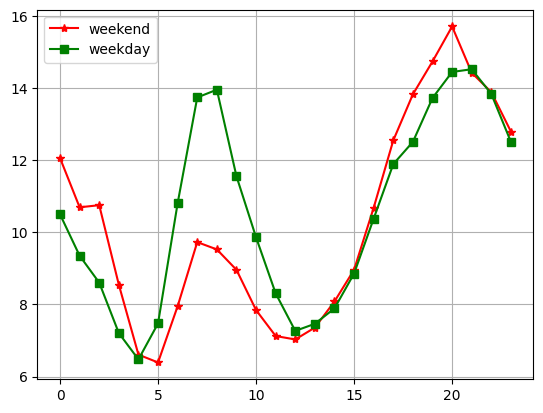

In [28]:
plt.plot(weekend_hourly_avg, marker='*', color='red',label='weekend')
plt.plot(weekday_hourly_avg, marker='s', color='green', label='weekday')

plt.grid()
plt.legend()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

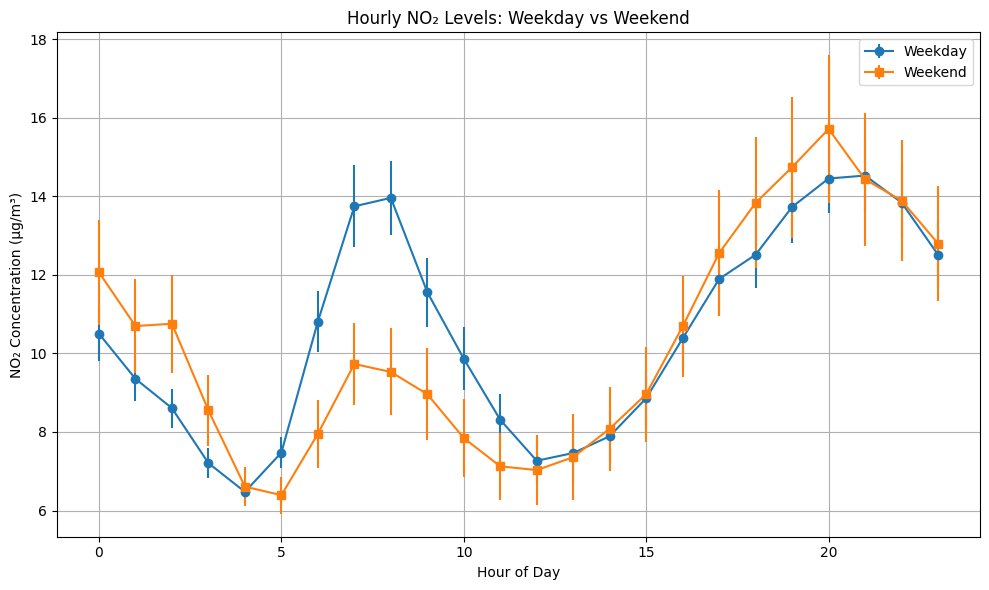

Hours with significant difference after correction: [5, 6, 7, 8, 9]


In [29]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Step 1: Preprocess
gp_no2['Timestamp'] = pd.to_datetime(gp_no2['Timestamp'])
gp_no2['hour'] = gp_no2['Timestamp'].dt.hour
gp_no2['weekday'] = gp_no2['Timestamp'].dt.weekday  # Monday=0, Sunday=6
gp_no2['is_weekend'] =gp_no2['weekday'] >= 5

# Separate
weekdays = gp_no2[~gp_no2['is_weekend']]
weekends = gp_no2[gp_no2['is_weekend']]

# Step 2: Aggregate means and SE
def mean_se_group(df):
    grouped = df.groupby('hour')['NO2']
    mean = grouped.mean()
    se = grouped.std() / np.sqrt(grouped.count())
    return mean, se

mean_wd, se_wd = mean_se_group(weekdays)
mean_we, se_we = mean_se_group(weekends)

# Step 3: Plot
hours = range(24)
plt.figure(figsize=(10,6))
plt.errorbar(hours, mean_wd, yerr=1.96*se_wd, label='Weekday', fmt='-o')
plt.errorbar(hours, mean_we, yerr=1.96*se_we, label='Weekend', fmt='-s')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂ Concentration (µg/m³)')
plt.title('Hourly NO₂ Levels: Weekday vs Weekend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Hour-wise t-tests
p_values = []
for hr in hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    _, p = ttest_ind(wd_vals, we_vals, equal_var=False)
    p_values.append(p)
# Correct for multiple testing (Bonferroni)
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Show significant hours
significant_hours = [hr for hr, sig in zip(hours, rejected) if sig]
print("Hours with significant difference after correction:", significant_hours)


In [30]:
# Step 5: Quantify differences for significant hours
results = []

for hr in significant_hours:
    wd_vals = weekdays[weekdays['hour'] == hr]['NO2']
    we_vals = weekends[weekends['hour'] == hr]['NO2']
    
    wd_mean = wd_vals.mean()
    we_mean = we_vals.mean()
    
    wd_std = wd_vals.std()
    we_std = we_vals.std()
    
    n_wd = len(wd_vals)
    n_we = len(we_vals)
    
    # Percent difference relative to weekend
    percent_diff = ((wd_mean - we_mean) / we_mean) * 100
    
    # Pooled standard deviation for Cohen's d
    pooled_std = np.sqrt(((n_wd - 1) * wd_std**2 + (n_we - 1) * we_std**2) / (n_wd + n_we - 2))
    cohens_d = (wd_mean - we_mean) / pooled_std
    
    results.append({
        'Hour': hr,
        'Weekday Mean': round(wd_mean, 2),
        'Weekend Mean': round(we_mean, 2),
        'Mean Difference': round(wd_mean - we_mean, 2),
        '% Difference': round(percent_diff, 2),
        "Cohen's d": round(cohens_d, 2),
        'Direction': 'Weekday > Weekend' if wd_mean > we_mean else 'Weekday < Weekend'
    })

# Create and display DataFrame
diff_summary = pd.DataFrame(results)
diff_summary

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Hour,Weekday Mean,Weekend Mean,Mean Difference,% Difference,Cohen's d,Direction
0,5,7.48,6.39,1.08,16.96,0.39,Weekday > Weekend
1,6,10.81,7.95,2.86,35.94,0.53,Weekday > Weekend
2,7,13.74,9.73,4.01,41.25,0.57,Weekday > Weekend
3,8,13.96,9.53,4.43,46.51,0.68,Weekday > Weekend
4,9,11.56,8.96,2.60,28.97,0.42,Weekday > Weekend
